<a href="https://colab.research.google.com/github/HuinaGabriela/Fast_CNN_Classifier_with_VGG16/blob/main/Conhe%C3%A7a_o_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import files

# uploaded = files.upload()

Saving classificador_de_imagens.zip to classificador_de_imagens.zip


In [3]:
# import zipfile
# import os

# # Nome do arquivo conforme aparece no upload
# zip_file = 'classificador_de_imagens.zip'

# # Extrai os arquivos para uma nova pasta chamada 'meu_projeto'
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall('meu_projeto')

# # Lista os arquivos extraídos
# os.listdir('meu_projeto')

['classificador_de_imagens']

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# import os

# # Lista arquivos da pasta de treino de gatos
# cat_images = os.listdir('/content/meu_projeto/classificador_de_imagens/dataset/train/cats')
# print(f'Número de imagens de gato: {len(cat_images)}')
# print('Exemplos:', cat_images[:5])



Número de imagens de gato: 80
Exemplos: ['cat.4054.jpg', 'cat.4090.jpg', 'cat.4026.jpg', 'cat.4057.jpg', 'cat.4006.jpg']


In [11]:
# import os

# # Lista arquivos da pasta de treino de dogs
# dog_images = os.listdir('/content/meu_projeto/classificador_de_imagens/dataset/train/dogs')
# print(f'Número de imagens de dogs: {len(dog_images)}')
# print('Exemplos:', dog_images[:5])

Número de imagens de dogs: 80
Exemplos: ['dog.4019.jpg', 'dog.4049.jpg', 'dog.4080.jpg', 'dog.4090.jpg', 'dog.4058.jpg']


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Caminho base do dataset
base_dir = '/content/meu_projeto/classificador_de_imagens/dataset'

# Caminhos específicos
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parâmetros
img_size = (224, 224)
batch_size = 16

# Aumento de dados (data augmentation) apenas para o treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Apenas normalização para validação e teste
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 160 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Found 160 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
### Treinando só o classificador (base congelada) ###


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5017 - loss: 1.0090 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.5072 - loss: 0.9960 - val_accuracy: 0.6000 - val_loss: 0.6420
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 130s 13s/step - accuracy: 0.6057 - loss: 0.6436 - val_accuracy: 0.7500 - val_loss: 0.5058
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 13s/step - accuracy: 0.7323 - loss: 0.4843 - val_accuracy: 0.8000 - val_loss: 0.4862
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 13s/step - accuracy: 0.8413 - loss: 0.3961 - val_accuracy: 0.8500 - val_loss: 0.4133
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 126s 13s/step - accuracy: 0.8438 - loss: 0.3896 - val_accuracy: 0.8000 - val_loss: 0.4241
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 12s/step - accuracy: 0.8820 - loss: 0.3024 - val_accuracy: 0.8000 - val_loss: 0.4574
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 13s/step - accuracy: 0.8681 - loss: 0.3191 - val_accuracy: 0.8000 - val_loss: 0.4490
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 133s 12s/step - accuracy: 0.9124 - loss: 0.2770 - val_accuracy: 0.8500 - val_

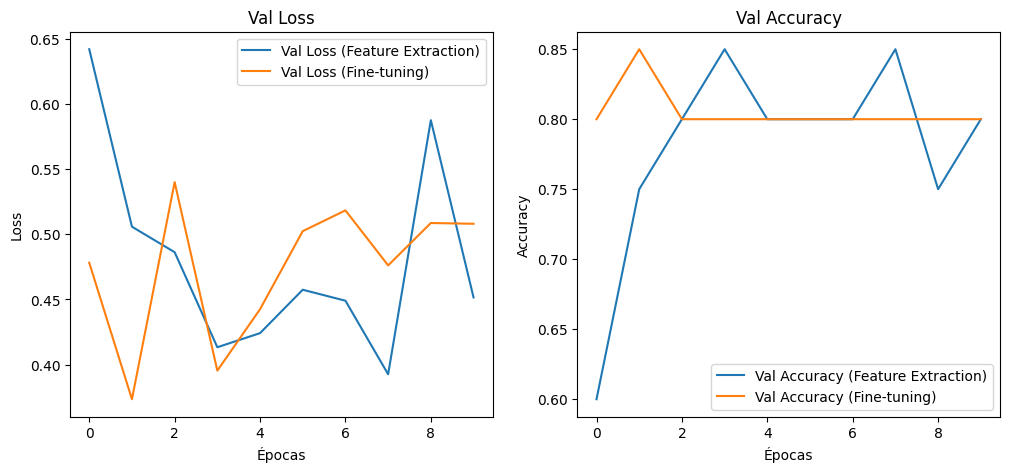

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8917 - loss: 0.2841
Test loss: 0.2623
Test accuracy: 0.9000


In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# ------------------
# CAMINHOS CORRETOS NO COLAB
train_dir = '/content/meu_projeto/classificador_de_imagens/dataset/train'
val_dir   = '/content/meu_projeto/classificador_de_imagens/dataset/val'
test_dir  = '/content/meu_projeto/classificador_de_imagens/dataset/test'

# CONFIGURAÇÃO DE CAMINHOS E PARÂMETROS
# train_dir = 'dataset/train'
# val_dir = 'dataset/val'
# test_dir = 'dataset/test'

img_size = (224, 224) # Tamanho padrão de entrada da VGG16
batch_size = 16
num_classes = 2 # Número de classes (ex: 'cats' e 'dogs')

# ------------------
# PREPARAÇÃO DOS DADOS

# Aumento de dados ("data augmentation") apenas para o conjunto de treino
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normaliza os pixels para [0, 1]
    rotation_range=20, # Rotação aleatória de até 20 graus
    width_shift_range=0.1, # Deslocamento horizontal
    height_shift_range=0.1, # Deslocamento vertical
    shear_range=0.1, # Cisalhamento
    zoom_range=0.2, # Zoom
    horizontal_flip=True # Espelhamento horizontal
)
# Apenas normalização para validação e teste
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Geração dos lotes de imagens
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical' # Uma saída por classe
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Necessário para avaliação e predição com ordem conhecida
)

# ------------------
# CONSTRUÇÃO DO MODELO USANDO TRANSFER LEARNING COM VGG16

# Carrega a VGG16 pré-treinada no ImageNet, sem o topo (camadas densas)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar todas as camadas da base inicialmente

# Adiciona o classificador customizado sobre a base congelada
model = Sequential([
    base_model,
    Flatten(), # Achata os mapas de ativação
    Dense(256, activation='relu'), # Camada totalmente conectada
    Dropout(0.5), # Regularização para evitar overfitting
    Dense(num_classes, activation='softmax') # Camada de saída
])

# Compila o modelo para treinamento do classificador
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinamento inicial apenas do classificador (base congelada)
print("### Treinando só o classificador (base congelada) ###")
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# ------------------
# FINE-TUNING: DESCONGELANDO CAMADAS SUPERIORES DA BASE

# Permite o fine-tuning da base, mas apenas das últimas 4 camadas convolucionais VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False # Mantém congeladas as camadas inferiores

# Compilação com taxa de aprendizado menor para fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # LR menor para fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinamento com fine-tuning (ajuste fino das últimas camadas da base)
print("### Fine-tuning das últimas camadas da base VGG16 ###")
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# ------------------
# SALVAMENTO DO MODELO TREINADO
model.save('vgg16_transfer_finetuned.keras')
print("Modelo salvo em 'vgg16_transfer_finetuned.h5'")

# ------------------
# VISUALIZAÇÃO DO DESEMPENHO (LOSS E ACURÁCIA POR ÉPOCA)
def plot_training(history1, history2):
    """
    Compara as curvas de validação antes e depois do fine-tuning.
    """
    plt.figure(figsize=(12, 5))

    # Validação - Loss
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_loss'], label='Val Loss (Feature Extraction)')
    plt.plot(history2.history['val_loss'], label='Val Loss (Fine-tuning)')
    plt.title('Val Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Validação - Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_accuracy'], label='Val Accuracy (Feature Extraction)')
    plt.plot(history2.history['val_accuracy'], label='Val Accuracy (Fine-tuning)')
    plt.title('Val Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training(history, history_fine)

# ------------------
# AVALIAÇÃO FINAL DO MODELO NO CONJUNTO DE TESTE
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# ------------------
# FUNÇÕES DE PREDIÇÃO PARA IMAGEM NOVA
def prepare_image(img_path):
    """
    Pré-processa uma imagem individual para predição:
    - Redimensiona
    - Normaliza os pixels
    - Expande as dimensões (para formato de batch)
    """
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    return x

# Dicionário de mapeamento: índice -> nome da classe
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Função para prever classe de imagem nova
def predict_image(img_path):
    """
    Realiza a predição da imagem informada e imprime a classe prevista com a probabilidade associada.
    """
    x = prepare_image(img_path)
    preds = model.predict(x)
    class_idx = np.argmax(preds)
    class_name = inv_class_indices[class_idx]
    confidence = preds[0][class_idx]
    print(f'Imagem: {img_path}')
    print(f'Classe prevista: {class_name} ({confidence*100:.2f}%)')


In [15]:
import os
os.listdir('/content/meu_projeto/classificador_de_imagens/dataset')


['train', 'test', 'val', 'div_imagens.ipynb']